In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch, torchvision 
from PIL import Image

In [3]:
df_infos4 = pd.read_csv('../saved/infos4.csv')

In [4]:
import pickle
with open('../saved/data_imgs2.pkl', 'rb') as f:
    data_imgs2 = pickle.load(f)

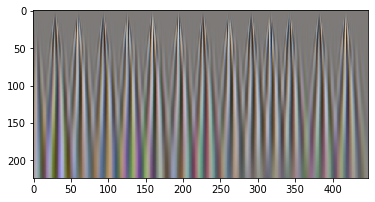

In [5]:
plt.imshow(data_imgs2[5][3])

In [6]:
n_segments = 5
def crop_imgs(data_img, n_segments = n_segments, vis = False):
    
    shift_len = int((data_img[0].size[0]-224) / (n_segments-1))
    if vis:
        plt.imshow(data_img)
        plt.show()
        
    # each imgs
    imgs = []
    for i in range(n_segments):
        
        # each channel of each segment
        img_chns = []
        for chn in range(4):
            img = data_img[chn].crop((i*shift_len,0,i*shift_len+224,224)) # 0, 0, 224, 224 left, upper, right, and lower
            img_chns.append(img)
            
            if vis:
                plt.imshow(img)
                plt.show()
                
        imgs.append(img_chns)
    return imgs

data_img2_crops = []
for i in tqdm(range(len(data_imgs2))):
    data_img2_crops += crop_imgs(data_imgs2[i])
    

In [7]:
df_infos4_crops = df_infos4.loc[df_infos4.index.repeat(5)].reset_index(drop=True)

In [8]:
from torch.utils.data import Dataset
from torchvision import transforms
from global_vars import labels
import os
class MyImageMultichannelDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, infos, n_segments, channel_imgs):
        """
                
        channel_imgs = chn -> array of PImage
        """
        self.infos = infos
        self.channel_imgs = channel_imgs
        self.n_segments = n_segments
        self.transform =  transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         ])

    def __len__(self):
        return len(self.infos)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        images = [self.channel_imgs[idx][chn] for chn in range(4)]
        info_labels = self.infos.iloc[idx][labels]
        sample =(torch.cat([self.transform(image) for image in images],0), torch.Tensor(info_labels.astype(int)))

        return sample
    
image_datasets = MyImageMultichannelDataset(df_infos4_crops, n_segments, data_img2_crops)

In [9]:
imgs0, label0 = image_datasets[0]
# assert len(imgs0) == 4
# assert imgs0[0].shape == (3, 224, 224)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [12]:
from torch import nn
from torchvision import models
    
class MultiCWTNet(nn.Module):
    def __init__(self, device, verbose=False):
        super(MultiCWTNet, self).__init__()
        
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.conv1 = self.increase_channels(self.resnet.conv1, num_channels=12, copy_weights=0)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 9)

        self.verbose = verbose
        
    def forward(self, xs):
        x = self.resnet(xs)
        return x
    
    
    def increase_channels(self, m, num_channels=None, copy_weights=0):
        """
        https://github.com/akashpalrecha/Resnet-multichannel/blob/master/multichannel_resnet.py
        
        takes as input a Conv2d layer and returns the a Conv2d layer with `num_channels` input channels
        and all the previous weights copied into the new layer.
        """
        # number of input channels the new module should have
        new_in_channels = num_channels if num_channels is not None else m.in_channels + 1
        
        # Creating new Conv2d layer
        new_m = nn.Conv2d(in_channels=new_in_channels, 
                          out_channels=m.out_channels, 
                          kernel_size=m.kernel_size, 
                          stride=m.stride, 
                          padding=m.padding,
                          bias=False)
        
        # Copying the weights from the old to the new layer
        new_m.weight[:, :m.in_channels, :, :] = m.weight.clone()
        
        #Copying the weights of the `copy_weights` channel of the old layer to the extra channels of the new layer
        for i in range(new_in_channels - m.in_channels):
            channel = m.in_channels + i
            new_m.weight[:, channel:channel+1, :, :] = m.weight[:, copy_weights:copy_weights+1, : :].clone()
        new_m.weight = nn.Parameter(new_m.weight)

        return new_m

In [13]:
def geometry_loss(fbeta, gbeta):
    return np.sqrt(fbeta*gbeta)

#geometry_loss(fbeta2, gbeta2)

In [ ]:
from torchvision import datasets, models, transforms
from myeval import binary_acc
import torch.optim as optim
from torch.optim import lr_scheduler
from snippets.pytorchtools import EarlyStopping
from sklearn.model_selection import GroupKFold
import time

st = time.time()
patience = 20
kf = GroupKFold(5)
batch_size=70

saved_dir = '../saved/modelMultiCWTFullUnbalanced/'
y = df_infos4_crops[labels].astype(int)

for i, (train_idx, test_idx) in enumerate(kf.split(df_infos4_crops, y, df_infos4_crops['ptID'])):

    df_y_train = df_infos4_crops.iloc[train_idx][labels].to_numpy().astype(int)
    class_weights = 1.0/np.sum(df_y_train,axis=0)
    class_weights = class_weights / np.sum(class_weights)
    class_weights = torch.Tensor(class_weights).to(device)
    
    trainDataset = torch.utils.data.Subset(image_datasets, train_idx)
    testDataset = torch.utils.data.Subset(image_datasets, test_idx)
    
    trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, shuffle = True, pin_memory=True)#sampler = sampler)
    testLoader = torch.utils.data.DataLoader(testDataset, batch_size = batch_size, shuffle = False, pin_memory=True)

    model = MultiCWTNet(device, verbose=False)
    model.to(device)
    
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #
    # Decay LR by a factor of 0.1 every 100 epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    pos_weight = np.ones(9) * 2
    pos_weight = torch.Tensor(pos_weight).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)#, weight=class_weights, reduction='sum')

    losses_train = []
    losses_test = []

    avg_losses_train = []
    avg_losses_test = []


    early_stopping = EarlyStopping(patience, verbose=False, 
                                  saved_dir=saved_dir, 
                                   save_name='MutliCWTNetFull'+str(i))
    epoch = 0
    auroc = 0
    auprc = 0
    accuracy = 0
    fmeasure = 0
    fbeta = 0
    gbeta = 0
    for epoch in range(1000):
        
        model.train()
        output_trains = []
        y_trains = []
        for X_train, y_train in tqdm(trainLoader):
            y_train = y_train.to(device)
            X_train = X_train.to(device)
            optimizer.zero_grad()
            output_train = model(X_train)
            
            loss_train = criterion(output_train, y_train)
            losses_train.append(loss_train.item())
            loss_train.backward()
            optimizer.step()
            
            output_trains.append(output_train.cpu())
            y_trains.append(y_train.cpu())

        scheduler.step()
        
        avg_loss_train = np.average(losses_train)
        avg_losses_train.append(avg_loss_train)
        
        output_tests = []
        y_tests = []
        with torch.no_grad():
            model.eval()
            
            for X_test, y_test in testLoader:  
                y_test = y_test.to(device)
                X_test = X_test.to(device)
                output_test = model(X_test)
                
                loss_test = criterion(output_test, y_test)
                losses_test.append(loss_test.item())
                
                output_tests.append(output_test.cpu())
                y_tests.append(y_test.cpu())
                
            avg_loss_test = np.average(losses_test)
            avg_losses_test.append(avg_loss_test)

       
        
        output_trains = torch.cat(output_trains, axis=0)
        y_train_preds = torch.sigmoid(output_trains)
        y_trains = torch.cat(y_trains, axis=0)
        acc, fmeasure, fbeta, gbeta, auroc, auprc = binary_acc(y_train_preds, y_trains)

        output_tests = torch.cat(output_tests, axis=0)
        y_test_preds = torch.sigmoid(output_tests)
        y_tests = torch.cat(y_tests, axis=0)
        acc2, fmeasure2, fbeta2, gbeta2, auroc2, auprc2 = binary_acc(y_test_preds, y_tests)

        geometry = geometry_loss(fbeta, gbeta)
        geometry2 = geometry_loss(fbeta2, gbeta2)
        output_str = 'S{}/{} {:.2f} min|\nTrain Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, auroc: {:.3f}, auprc: {:.3f}, geo: {:.3f} |\nValid Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, auroc: {:.3f}, auprc: {:.3f}, geo: {:.3f}\n '.format(
            i, epoch, (time.time()-st)/60,
            avg_loss_train, acc, fmeasure, fbeta, gbeta, auroc, auprc, geometry,
            avg_loss_test, acc2, fmeasure2, fbeta2, gbeta2, auroc2, auprc2, geometry2)
        print(output_str)
        
        with open(saved_dir+'loss{}.txt'.format(i), 'a') as f:
            print(output_str, file=f)
            
        early_stopping(-geometry2, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    output_string = 'AUROC|AUPRC|Accuracy|F-measure|Fbeta-measure|Gbeta-measure\n{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}'.format(auroc2,auprc2,acc2,fmeasure2,fbeta2,gbeta2)
    print(output_string)     
    with open(saved_dir+'score'+ str(i)+ '_epoch' + str(epoch) + '.txt', 'w') as f:
        f.write(output_string)

    avg_losses_train = np.array(avg_losses_train)
    avg_losses_test = np.array(avg_losses_test)
    
    np.save(saved_dir + 'avg_losses_train' + str(i) + '_epoch' + str(epoch), avg_losses_train)
    np.save(saved_dir + 'avg_losses_test' + str(i) + '_epoch' + str(epoch), avg_losses_test)
    


S0/0 13.07 min|
Train Loss: 0.433202, Acc: 0.896, F: 0.203, Fbeta: 0.238, gbeta: 0.105, auroc: 0.789, auprc: 0.359, geo: 0.158 |
Valid Loss: 0.351533, Acc: 0.914, F: 0.372, Fbeta: 0.402, gbeta: 0.220, auroc: 0.872, auprc: 0.554, geo: 0.297
 



S0/1 26.26 min|
Train Loss: 0.360294, Acc: 0.931, F: 0.519, Fbeta: 0.540, gbeta: 0.335, auroc: 0.911, auprc: 0.647, geo: 0.426 |
Valid Loss: 0.318726, Acc: 0.927, F: 0.532, Fbeta: 0.540, gbeta: 0.339, auroc: 0.910, auprc: 0.657, geo: 0.428
 



S0/2 39.07 min|
Train Loss: 0.313521, Acc: 0.946, F: 0.629, Fbeta: 0.642, gbeta: 0.445, auroc: 0.946, auprc: 0.746, geo: 0.535 |
Valid Loss: 0.296620, Acc: 0.935, F: 0.606, Fbeta: 0.615, gbeta: 0.409, auroc: 0.928, auprc: 0.704, geo: 0.501
 



S0/3 51.87 min|
Train Loss: 0.279165, Acc: 0.957, F: 0.703, Fbeta: 0.717, gbeta: 0.524, auroc: 0.967, auprc: 0.809, geo: 0.613 |
Valid Loss: 0.283409, Acc: 0.938, F: 0.638, Fbeta: 0.649, gbeta: 0.435, auroc: 0.933, auprc: 0.721, geo: 0.531
 



S0/4 64.67 min|
Train Loss: 0.251158, Acc: 0.967, F: 0.769, Fbeta: 0.785, gbeta: 0.602, auroc: 0.980, auprc: 0.859, geo: 0.688 |
Valid Loss: 0.275683, Acc: 0.939, F: 0.654, Fbeta: 0.661, gbeta: 0.450, auroc: 0.935, auprc: 0.723, geo: 0.546
 



S0/5 77.41 min|
Train Loss: 0.227257, Acc: 0.975, F: 0.821, Fbeta: 0.835, gbeta: 0.670, auroc: 0.989, auprc: 0.901, geo: 0.748 |
Valid Loss: 0.273578, Acc: 0.938, F: 0.651, Fbeta: 0.657, gbeta: 0.439, auroc: 0.932, auprc: 0.727, geo: 0.537
 



S0/6 90.11 min|
Train Loss: 0.206490, Acc: 0.982, F: 0.869, Fbeta: 0.881, gbeta: 0.737, auroc: 0.994, auprc: 0.936, geo: 0.806 |
Valid Loss: 0.270876, Acc: 0.942, F: 0.671, Fbeta: 0.682, gbeta: 0.467, auroc: 0.935, auprc: 0.731, geo: 0.565
 



S0/7 102.88 min|
Train Loss: 0.188249, Acc: 0.988, F: 0.906, Fbeta: 0.916, gbeta: 0.800, auroc: 0.997, auprc: 0.964, geo: 0.856 |
Valid Loss: 0.269780, Acc: 0.942, F: 0.676, Fbeta: 0.687, gbeta: 0.470, auroc: 0.935, auprc: 0.737, geo: 0.568
 



S0/8 115.61 min|
Train Loss: 0.172460, Acc: 0.992, F: 0.936, Fbeta: 0.943, gbeta: 0.852, auroc: 0.999, auprc: 0.980, geo: 0.896 |
Valid Loss: 0.270795, Acc: 0.942, F: 0.681, Fbeta: 0.692, gbeta: 0.473, auroc: 0.932, auprc: 0.732, geo: 0.572
 



S0/9 128.33 min|
Train Loss: 0.158690, Acc: 0.994, F: 0.958, Fbeta: 0.962, gbeta: 0.894, auroc: 0.999, auprc: 0.991, geo: 0.928 |
Valid Loss: 0.272050, Acc: 0.943, F: 0.681, Fbeta: 0.693, gbeta: 0.477, auroc: 0.931, auprc: 0.741, geo: 0.575
 



S0/10 141.06 min|
Train Loss: 0.146621, Acc: 0.997, F: 0.975, Fbeta: 0.977, gbeta: 0.933, auroc: 1.000, auprc: 0.996, geo: 0.955 |
Valid Loss: 0.272620, Acc: 0.945, F: 0.688, Fbeta: 0.703, gbeta: 0.482, auroc: 0.932, auprc: 0.746, geo: 0.582
 



S0/11 153.73 min|
Train Loss: 0.136428, Acc: 0.997, F: 0.977, Fbeta: 0.979, gbeta: 0.939, auroc: 1.000, auprc: 0.997, geo: 0.959 |
Valid Loss: 0.273166, Acc: 0.944, F: 0.689, Fbeta: 0.703, gbeta: 0.482, auroc: 0.933, auprc: 0.747, geo: 0.582
 



S0/12 166.43 min|
Train Loss: 0.127718, Acc: 0.997, F: 0.978, Fbeta: 0.981, gbeta: 0.942, auroc: 1.000, auprc: 0.997, geo: 0.961 |
Valid Loss: 0.273687, Acc: 0.945, F: 0.689, Fbeta: 0.703, gbeta: 0.485, auroc: 0.933, auprc: 0.748, geo: 0.584
 



S0/13 179.08 min|
Train Loss: 0.120192, Acc: 0.997, F: 0.979, Fbeta: 0.981, gbeta: 0.945, auroc: 1.000, auprc: 0.998, geo: 0.963 |
Valid Loss: 0.274058, Acc: 0.945, F: 0.690, Fbeta: 0.706, gbeta: 0.487, auroc: 0.934, auprc: 0.749, geo: 0.586
 



S0/14 191.76 min|
Train Loss: 0.113647, Acc: 0.998, F: 0.980, Fbeta: 0.983, gbeta: 0.948, auroc: 1.000, auprc: 0.998, geo: 0.965 |
Valid Loss: 0.274654, Acc: 0.945, F: 0.691, Fbeta: 0.705, gbeta: 0.485, auroc: 0.933, auprc: 0.749, geo: 0.585
 



S0/15 204.42 min|
Train Loss: 0.107862, Acc: 0.998, F: 0.980, Fbeta: 0.983, gbeta: 0.949, auroc: 1.000, auprc: 0.998, geo: 0.966 |
Valid Loss: 0.275366, Acc: 0.944, F: 0.690, Fbeta: 0.704, gbeta: 0.484, auroc: 0.932, auprc: 0.747, geo: 0.583
 


S0/16 217.05 min|
Train Loss: 0.102741, Acc: 0.998, F: 0.982, Fbeta: 0.984, gbeta: 0.951, auroc: 1.000, auprc: 0.998, geo: 0.967 |
Valid Loss: 0.275862, Acc: 0.945, F: 0.692, Fbeta: 0.706, gbeta: 0.487, auroc: 0.932, auprc: 0.748, geo: 0.587
 



S0/17 229.76 min|
Train Loss: 0.098137, Acc: 0.998, F: 0.982, Fbeta: 0.985, gbeta: 0.953, auroc: 1.000, auprc: 0.998, geo: 0.969 |
Valid Loss: 0.276352, Acc: 0.945, F: 0.689, Fbeta: 0.705, gbeta: 0.485, auroc: 0.932, auprc: 0.748, geo: 0.585
 



S0/18 242.50 min|
Train Loss: 0.093988, Acc: 0.998, F: 0.983, Fbeta: 0.986, gbeta: 0.956, auroc: 1.000, auprc: 0.999, geo: 0.971 |
Valid Loss: 0.276834, Acc: 0.946, F: 0.693, Fbeta: 0.708, gbeta: 0.488, auroc: 0.933, auprc: 0.748, geo: 0.588
 



S0/19 255.12 min|
Train Loss: 0.090246, Acc: 0.998, F: 0.984, Fbeta: 0.986, gbeta: 0.958, auroc: 1.000, auprc: 0.999, geo: 0.972 |
Valid Loss: 0.277232, Acc: 0.945, F: 0.689, Fbeta: 0.705, gbeta: 0.484, auroc: 0.933, auprc: 0.749, geo: 0.584
 



S0/20 267.81 min|
Train Loss: 0.086833, Acc: 0.998, F: 0.984, Fbeta: 0.986, gbeta: 0.958, auroc: 1.000, auprc: 0.999, geo: 0.972 |
Valid Loss: 0.277637, Acc: 0.945, F: 0.692, Fbeta: 0.707, gbeta: 0.487, auroc: 0.933, auprc: 0.750, geo: 0.587
 



S0/21 280.40 min|
Train Loss: 0.083715, Acc: 0.998, F: 0.986, Fbeta: 0.988, gbeta: 0.963, auroc: 1.000, auprc: 0.999, geo: 0.976 |
Valid Loss: 0.277979, Acc: 0.946, F: 0.692, Fbeta: 0.708, gbeta: 0.489, auroc: 0.933, auprc: 0.750, geo: 0.588
 



S0/22 293.07 min|
Train Loss: 0.080872, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.960, auroc: 1.000, auprc: 0.999, geo: 0.973 |
Valid Loss: 0.278410, Acc: 0.945, F: 0.691, Fbeta: 0.705, gbeta: 0.484, auroc: 0.932, auprc: 0.749, geo: 0.584
 



S0/23 305.71 min|
Train Loss: 0.078269, Acc: 0.998, F: 0.984, Fbeta: 0.986, gbeta: 0.957, auroc: 1.000, auprc: 0.999, geo: 0.971 |
Valid Loss: 0.278743, Acc: 0.945, F: 0.690, Fbeta: 0.706, gbeta: 0.485, auroc: 0.933, auprc: 0.749, geo: 0.585
 



S0/24 318.39 min|
Train Loss: 0.075859, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.960, auroc: 1.000, auprc: 0.999, geo: 0.973 |
Valid Loss: 0.279113, Acc: 0.945, F: 0.687, Fbeta: 0.703, gbeta: 0.482, auroc: 0.932, auprc: 0.748, geo: 0.582
 



S0/25 331.01 min|
Train Loss: 0.073641, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.960, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.279455, Acc: 0.945, F: 0.691, Fbeta: 0.706, gbeta: 0.486, auroc: 0.933, auprc: 0.749, geo: 0.586
 



S0/26 343.58 min|
Train Loss: 0.071576, Acc: 0.998, F: 0.986, Fbeta: 0.988, gbeta: 0.962, auroc: 1.000, auprc: 0.999, geo: 0.975 |
Valid Loss: 0.279751, Acc: 0.945, F: 0.690, Fbeta: 0.705, gbeta: 0.485, auroc: 0.933, auprc: 0.749, geo: 0.584
 



S0/27 356.14 min|
Train Loss: 0.069665, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.280025, Acc: 0.945, F: 0.690, Fbeta: 0.706, gbeta: 0.486, auroc: 0.932, auprc: 0.749, geo: 0.586
 



S0/28 368.65 min|
Train Loss: 0.067884, Acc: 0.998, F: 0.986, Fbeta: 0.988, gbeta: 0.962, auroc: 1.000, auprc: 0.999, geo: 0.975 |
Valid Loss: 0.280306, Acc: 0.945, F: 0.689, Fbeta: 0.705, gbeta: 0.484, auroc: 0.932, auprc: 0.748, geo: 0.584
 



S0/29 381.14 min|
Train Loss: 0.066221, Acc: 0.998, F: 0.986, Fbeta: 0.988, gbeta: 0.962, auroc: 1.000, auprc: 0.999, geo: 0.975 |
Valid Loss: 0.280558, Acc: 0.945, F: 0.687, Fbeta: 0.703, gbeta: 0.483, auroc: 0.933, auprc: 0.749, geo: 0.582
 



S0/30 393.65 min|
Train Loss: 0.064667, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.959, auroc: 1.000, auprc: 0.999, geo: 0.973 |
Valid Loss: 0.280762, Acc: 0.946, F: 0.693, Fbeta: 0.708, gbeta: 0.489, auroc: 0.933, auprc: 0.751, geo: 0.589
 



S0/31 406.14 min|
Train Loss: 0.063208, Acc: 0.998, F: 0.986, Fbeta: 0.987, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.280947, Acc: 0.945, F: 0.692, Fbeta: 0.706, gbeta: 0.487, auroc: 0.933, auprc: 0.750, geo: 0.586
 



S0/32 418.66 min|
Train Loss: 0.061835, Acc: 0.998, F: 0.986, Fbeta: 0.987, gbeta: 0.962, auroc: 1.000, auprc: 0.999, geo: 0.975 |
Valid Loss: 0.281098, Acc: 0.945, F: 0.692, Fbeta: 0.707, gbeta: 0.486, auroc: 0.933, auprc: 0.749, geo: 0.586
 



S0/33 431.16 min|
Train Loss: 0.060547, Acc: 0.998, F: 0.984, Fbeta: 0.986, gbeta: 0.958, auroc: 1.000, auprc: 0.999, geo: 0.972 |
Valid Loss: 0.281308, Acc: 0.946, F: 0.690, Fbeta: 0.706, gbeta: 0.487, auroc: 0.933, auprc: 0.750, geo: 0.587
 



S0/34 443.64 min|
Train Loss: 0.059333, Acc: 0.998, F: 0.986, Fbeta: 0.987, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.281479, Acc: 0.945, F: 0.689, Fbeta: 0.704, gbeta: 0.484, auroc: 0.932, auprc: 0.748, geo: 0.584
 



S0/35 456.11 min|
Train Loss: 0.058184, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.281658, Acc: 0.945, F: 0.687, Fbeta: 0.704, gbeta: 0.483, auroc: 0.933, auprc: 0.749, geo: 0.583
 



S0/36 468.55 min|
Train Loss: 0.057103, Acc: 0.998, F: 0.986, Fbeta: 0.988, gbeta: 0.962, auroc: 1.000, auprc: 0.999, geo: 0.975 |
Valid Loss: 0.281793, Acc: 0.945, F: 0.687, Fbeta: 0.703, gbeta: 0.482, auroc: 0.933, auprc: 0.749, geo: 0.582
 



S0/37 481.01 min|
Train Loss: 0.056072, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.960, auroc: 1.000, auprc: 0.999, geo: 0.973 |
Valid Loss: 0.281889, Acc: 0.945, F: 0.691, Fbeta: 0.706, gbeta: 0.487, auroc: 0.933, auprc: 0.750, geo: 0.586
 



S0/38 493.48 min|
Train Loss: 0.055091, Acc: 0.998, F: 0.986, Fbeta: 0.988, gbeta: 0.962, auroc: 1.000, auprc: 0.999, geo: 0.975 |
Valid Loss: 0.282037, Acc: 0.945, F: 0.690, Fbeta: 0.706, gbeta: 0.487, auroc: 0.932, auprc: 0.750, geo: 0.586
 



S0/39 505.95 min|
Train Loss: 0.054160, Acc: 0.998, F: 0.985, Fbeta: 0.988, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.282159, Acc: 0.945, F: 0.690, Fbeta: 0.705, gbeta: 0.485, auroc: 0.933, auprc: 0.750, geo: 0.585
 



S0/40 518.51 min|
Train Loss: 0.053279, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.960, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.282331, Acc: 0.945, F: 0.688, Fbeta: 0.704, gbeta: 0.483, auroc: 0.932, auprc: 0.749, geo: 0.583
 



S0/41 531.19 min|
Train Loss: 0.052436, Acc: 0.998, F: 0.986, Fbeta: 0.988, gbeta: 0.962, auroc: 1.000, auprc: 0.999, geo: 0.975 |
Valid Loss: 0.282445, Acc: 0.945, F: 0.690, Fbeta: 0.706, gbeta: 0.486, auroc: 0.932, auprc: 0.749, geo: 0.585
 



S0/42 543.86 min|
Train Loss: 0.051631, Acc: 0.998, F: 0.986, Fbeta: 0.987, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.282524, Acc: 0.945, F: 0.689, Fbeta: 0.705, gbeta: 0.484, auroc: 0.933, auprc: 0.751, geo: 0.584
 



S0/43 556.44 min|
Train Loss: 0.050873, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.960, auroc: 1.000, auprc: 0.999, geo: 0.973 |
Valid Loss: 0.282646, Acc: 0.945, F: 0.686, Fbeta: 0.702, gbeta: 0.481, auroc: 0.932, auprc: 0.749, geo: 0.581
 



S0/44 569.03 min|
Train Loss: 0.050145, Acc: 0.998, F: 0.984, Fbeta: 0.986, gbeta: 0.958, auroc: 1.000, auprc: 0.999, geo: 0.972 |
Valid Loss: 0.282777, Acc: 0.945, F: 0.687, Fbeta: 0.704, gbeta: 0.483, auroc: 0.932, auprc: 0.749, geo: 0.583
 



S0/45 581.64 min|
Train Loss: 0.049435, Acc: 0.998, F: 0.986, Fbeta: 0.988, gbeta: 0.962, auroc: 1.000, auprc: 0.999, geo: 0.975 |
Valid Loss: 0.282836, Acc: 0.946, F: 0.691, Fbeta: 0.707, gbeta: 0.488, auroc: 0.933, auprc: 0.750, geo: 0.587
 



S0/46 594.29 min|
Train Loss: 0.048762, Acc: 0.998, F: 0.986, Fbeta: 0.987, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.282973, Acc: 0.944, F: 0.686, Fbeta: 0.701, gbeta: 0.481, auroc: 0.931, auprc: 0.748, geo: 0.581
 



S0/47 606.88 min|
Train Loss: 0.048122, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.959, auroc: 1.000, auprc: 0.999, geo: 0.973 |
Valid Loss: 0.283052, Acc: 0.945, F: 0.694, Fbeta: 0.708, gbeta: 0.490, auroc: 0.932, auprc: 0.749, geo: 0.589
 



S0/48 619.41 min|
Train Loss: 0.047505, Acc: 0.998, F: 0.985, Fbeta: 0.988, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.283138, Acc: 0.945, F: 0.688, Fbeta: 0.704, gbeta: 0.483, auroc: 0.932, auprc: 0.750, geo: 0.583
 



S0/49 631.86 min|
Train Loss: 0.046912, Acc: 0.998, F: 0.986, Fbeta: 0.988, gbeta: 0.963, auroc: 1.000, auprc: 0.999, geo: 0.975 |
Valid Loss: 0.283208, Acc: 0.945, F: 0.693, Fbeta: 0.706, gbeta: 0.488, auroc: 0.933, auprc: 0.749, geo: 0.587
 



S0/50 644.36 min|
Train Loss: 0.046340, Acc: 0.998, F: 0.985, Fbeta: 0.988, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.283279, Acc: 0.945, F: 0.690, Fbeta: 0.704, gbeta: 0.485, auroc: 0.933, auprc: 0.750, geo: 0.584
 



S0/51 656.85 min|
Train Loss: 0.045794, Acc: 0.998, F: 0.986, Fbeta: 0.988, gbeta: 0.963, auroc: 1.000, auprc: 0.999, geo: 0.975 |
Valid Loss: 0.283328, Acc: 0.945, F: 0.688, Fbeta: 0.704, gbeta: 0.482, auroc: 0.933, auprc: 0.749, geo: 0.583
 



S0/52 669.28 min|
Train Loss: 0.045265, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.283402, Acc: 0.945, F: 0.691, Fbeta: 0.706, gbeta: 0.486, auroc: 0.933, auprc: 0.749, geo: 0.586
 



S0/53 681.75 min|
Train Loss: 0.044753, Acc: 0.998, F: 0.986, Fbeta: 0.988, gbeta: 0.963, auroc: 1.000, auprc: 0.999, geo: 0.975 |
Valid Loss: 0.283529, Acc: 0.945, F: 0.691, Fbeta: 0.706, gbeta: 0.485, auroc: 0.932, auprc: 0.750, geo: 0.585
 



S0/54 694.21 min|
Train Loss: 0.044270, Acc: 0.998, F: 0.986, Fbeta: 0.987, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.283584, Acc: 0.945, F: 0.685, Fbeta: 0.702, gbeta: 0.481, auroc: 0.932, auprc: 0.749, geo: 0.582
 



S0/55 706.66 min|
Train Loss: 0.043796, Acc: 0.998, F: 0.986, Fbeta: 0.988, gbeta: 0.962, auroc: 1.000, auprc: 0.999, geo: 0.975 |
Valid Loss: 0.283667, Acc: 0.945, F: 0.692, Fbeta: 0.707, gbeta: 0.488, auroc: 0.932, auprc: 0.748, geo: 0.587
 



S0/56 719.17 min|
Train Loss: 0.043332, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.283760, Acc: 0.945, F: 0.692, Fbeta: 0.707, gbeta: 0.488, auroc: 0.932, auprc: 0.748, geo: 0.587
 



S0/57 731.65 min|
Train Loss: 0.042891, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.960, auroc: 1.000, auprc: 0.999, geo: 0.973 |
Valid Loss: 0.283847, Acc: 0.945, F: 0.691, Fbeta: 0.706, gbeta: 0.487, auroc: 0.932, auprc: 0.748, geo: 0.587
 



S0/58 744.12 min|
Train Loss: 0.042464, Acc: 0.998, F: 0.987, Fbeta: 0.988, gbeta: 0.964, auroc: 1.000, auprc: 0.999, geo: 0.976 |
Valid Loss: 0.283917, Acc: 0.945, F: 0.691, Fbeta: 0.705, gbeta: 0.486, auroc: 0.933, auprc: 0.750, geo: 0.585
 



S0/59 756.62 min|
Train Loss: 0.042051, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.960, auroc: 1.000, auprc: 0.999, geo: 0.973 |
Valid Loss: 0.283948, Acc: 0.946, F: 0.690, Fbeta: 0.706, gbeta: 0.487, auroc: 0.932, auprc: 0.749, geo: 0.587
 



S0/60 769.05 min|
Train Loss: 0.041655, Acc: 0.998, F: 0.986, Fbeta: 0.988, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.283992, Acc: 0.945, F: 0.689, Fbeta: 0.705, gbeta: 0.486, auroc: 0.933, auprc: 0.750, geo: 0.585
 



S0/61 781.51 min|
Train Loss: 0.041275, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.960, auroc: 1.000, auprc: 0.999, geo: 0.973 |
Valid Loss: 0.284065, Acc: 0.945, F: 0.690, Fbeta: 0.705, gbeta: 0.484, auroc: 0.933, auprc: 0.750, geo: 0.584
 



S0/62 793.98 min|
Train Loss: 0.040900, Acc: 0.998, F: 0.986, Fbeta: 0.987, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.284109, Acc: 0.945, F: 0.689, Fbeta: 0.706, gbeta: 0.486, auroc: 0.932, auprc: 0.750, geo: 0.586
 



S0/63 806.46 min|
Train Loss: 0.040540, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.959, auroc: 1.000, auprc: 0.999, geo: 0.973 |
Valid Loss: 0.284141, Acc: 0.946, F: 0.690, Fbeta: 0.707, gbeta: 0.487, auroc: 0.933, auprc: 0.750, geo: 0.587
 



S0/64 818.99 min|
Train Loss: 0.040191, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.960, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.284189, Acc: 0.945, F: 0.688, Fbeta: 0.703, gbeta: 0.483, auroc: 0.933, auprc: 0.749, geo: 0.583
 



S0/65 831.42 min|
Train Loss: 0.039858, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.284235, Acc: 0.945, F: 0.690, Fbeta: 0.705, gbeta: 0.486, auroc: 0.933, auprc: 0.749, geo: 0.585
 



S0/66 843.85 min|
Train Loss: 0.039535, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.959, auroc: 1.000, auprc: 0.999, geo: 0.973 |
Valid Loss: 0.284293, Acc: 0.945, F: 0.688, Fbeta: 0.704, gbeta: 0.483, auroc: 0.933, auprc: 0.750, geo: 0.583
 



S0/67 856.29 min|
Train Loss: 0.039215, Acc: 0.998, F: 0.985, Fbeta: 0.987, gbeta: 0.961, auroc: 1.000, auprc: 0.999, geo: 0.974 |
Valid Loss: 0.284342, Acc: 0.945, F: 0.689, Fbeta: 0.704, gbeta: 0.484, auroc: 0.932, auprc: 0.750, geo: 0.584
 
Early stopping
AUROC|AUPRC|Accuracy|F-measure|Fbeta-measure|Gbeta-measure
0.932|0.750|0.945|0.689|0.704|0.484



S1/0 868.76 min|
Train Loss: 0.438440, Acc: 0.897, F: 0.189, Fbeta: 0.223, gbeta: 0.099, auroc: 0.778, auprc: 0.342, geo: 0.149 |
Valid Loss: 0.351500, Acc: 0.916, F: 0.355, Fbeta: 0.383, gbeta: 0.209, auroc: 0.856, auprc: 0.531, geo: 0.283
 



S1/1 881.30 min|
Train Loss: 0.368265, Acc: 0.927, F: 0.491, Fbeta: 0.515, gbeta: 0.308, auroc: 0.907, auprc: 0.628, geo: 0.398 |
Valid Loss: 0.314935, Acc: 0.931, F: 0.545, Fbeta: 0.555, gbeta: 0.356, auroc: 0.903, auprc: 0.647, geo: 0.444
 



S1/2 893.74 min|
Train Loss: 0.321021, Acc: 0.945, F: 0.621, Fbeta: 0.634, gbeta: 0.436, auroc: 0.944, auprc: 0.737, geo: 0.526 |
Valid Loss: 0.292682, Acc: 0.939, F: 0.600, Fbeta: 0.615, gbeta: 0.409, auroc: 0.921, auprc: 0.690, geo: 0.501
 



S1/3 906.24 min|
Train Loss: 0.285519, Acc: 0.956, F: 0.703, Fbeta: 0.717, gbeta: 0.522, auroc: 0.966, auprc: 0.807, geo: 0.612 |
Valid Loss: 0.278855, Acc: 0.941, F: 0.628, Fbeta: 0.644, gbeta: 0.427, auroc: 0.931, auprc: 0.717, geo: 0.524
 



S1/4 918.78 min|
Train Loss: 0.256417, Acc: 0.967, F: 0.775, Fbeta: 0.790, gbeta: 0.607, auroc: 0.979, auprc: 0.862, geo: 0.692 |
Valid Loss: 0.271451, Acc: 0.941, F: 0.633, Fbeta: 0.646, gbeta: 0.433, auroc: 0.933, auprc: 0.718, geo: 0.529
 



S1/5 931.32 min|
Train Loss: 0.231711, Acc: 0.976, F: 0.831, Fbeta: 0.845, gbeta: 0.679, auroc: 0.988, auprc: 0.906, geo: 0.757 |
Valid Loss: 0.266096, Acc: 0.943, F: 0.673, Fbeta: 0.686, gbeta: 0.458, auroc: 0.934, auprc: 0.720, geo: 0.560
 



S1/6 943.77 min|
Train Loss: 0.210167, Acc: 0.983, F: 0.880, Fbeta: 0.891, gbeta: 0.751, auroc: 0.994, auprc: 0.945, geo: 0.818 |
Valid Loss: 0.262762, Acc: 0.944, F: 0.672, Fbeta: 0.688, gbeta: 0.456, auroc: 0.936, auprc: 0.727, geo: 0.560
 



S1/7 956.25 min|
Train Loss: 0.191311, Acc: 0.989, F: 0.921, Fbeta: 0.928, gbeta: 0.819, auroc: 0.997, auprc: 0.971, geo: 0.872 |
Valid Loss: 0.262729, Acc: 0.942, F: 0.659, Fbeta: 0.673, gbeta: 0.444, auroc: 0.936, auprc: 0.723, geo: 0.546
 



S1/8 968.74 min|
Train Loss: 0.174839, Acc: 0.993, F: 0.947, Fbeta: 0.952, gbeta: 0.871, auroc: 0.999, auprc: 0.986, geo: 0.910 |
Valid Loss: 0.262644, Acc: 0.943, F: 0.673, Fbeta: 0.685, gbeta: 0.455, auroc: 0.933, auprc: 0.727, geo: 0.559
 
